In [28]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import add_dummy_feature, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet,LogisticRegression
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

from copy import deepcopy
from sklearn.metrics import root_mean_squared_error

from sklearn.datasets import load_iris

In [2]:
np.random.seed(42)
m = 100 # number of instances
X = 2 * np.random.rand(m, 1) #column vector
y = 4 + 3 * X + np.random.randn(m, 1) #column vector

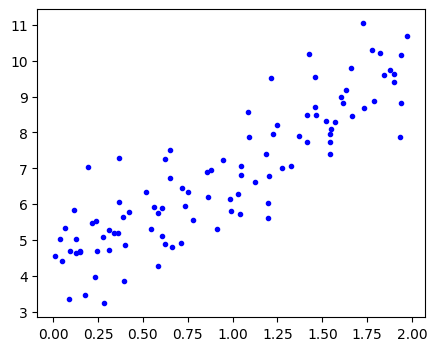

In [3]:
plt.figure(figsize=(5,4))
plt.plot(X, y, "b.")

In [4]:
# calculating normal equation
X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
print(theta_best, "best parameters from the values")
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
print(y_predict, "Predictions")

[[4.21509616]
 [2.77011339]] best parameters from the values
[[4.21509616]
 [9.75532293]] Predictions


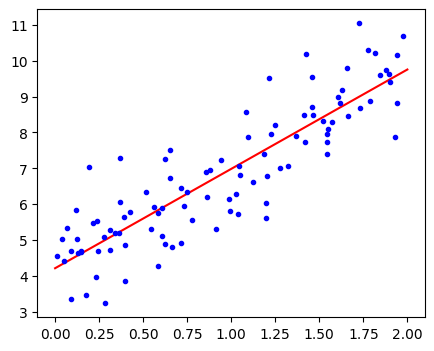

In [5]:
plt.figure(figsize=(5, 4))

plt.plot(X_new, y_predict, 'r-', label="Predictions")
plt.plot(X, y, 'b.')
plt.show()

In [6]:
# coding gradient descent
eta = .1 # learning rate
n_epochs = 1000
m = len(X_b) #number of instances

np.random.seed(42)
theta = np.random.randn(2,1) #randomly initialized model parameters

for _ in range(n_epochs):
    gradients = 2/m* X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

theta #last gradient theta values

array([[4.21509616],
       [2.77011339]])

In [7]:
# Manual stochastic gradient descent implementation
e_epochs = 50
t0, t1 = 5, 50 # learning rate

def learning_schedule(t):
    return t0/(t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1) #random initialzation

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index: random_index + 1]
        yi = y[random_index: random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi) # for SGD, do not devide by m
        eta = learning_schedule(epoch* m + iteration)
        theta = theta - eta * gradients
print(theta)

[[4.20492441]
 [2.76038824]]


In [8]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[4.21278812] [2.77270267]


In [9]:
# polynomial regression

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = .5 * X ** 2 + X + 2 + np.random.randn(m, 1)

In [10]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly_b = add_dummy_feature(X_poly)
print(X[0], X_poly[0])
theta = np.linalg.pinv(X_poly_b) @ y
print(theta)
pred_y = X_poly_b @ theta

[-0.75275929] [-0.75275929  0.56664654]
[[1.78134581]
 [0.93366893]
 [0.56456263]]


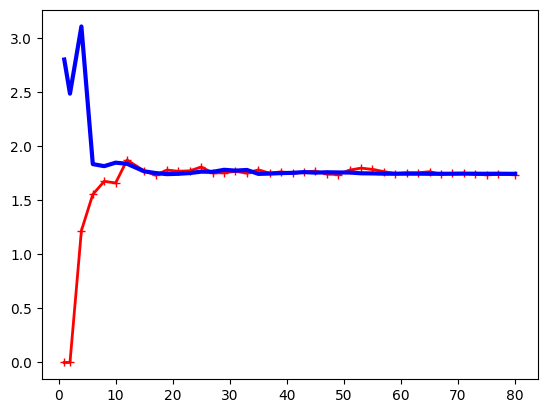

In [11]:
# Learning Curves

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(),X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="train")
plt.show()

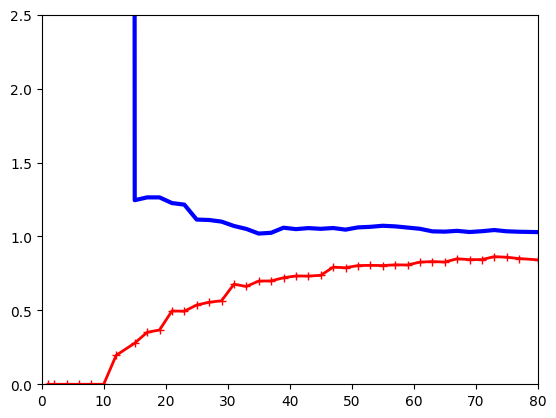

In [12]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression()
)
train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2,label='train')
plt.plot(train_sizes, valid_errors, "b-", linewidth=3,label='valid')
plt.axis([0, 80, 0, 2.5])
plt.show()

In [13]:
# Ridge Regression closed form solution (using matrix factorization technique)

ridge_reg = Ridge(alpha=0.1, solver='cholesky')
ridge_reg.fit(X, y.ravel())
ridge_reg.predict([[1.5]])

# using stochastic gradient descent

sgd_reg = SGDRegressor(penalty="l2", alpha=0.1/m, tol=None, max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.82830117])

In [14]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

In [15]:
# Elastic net regression
elast_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
elast_reg.fit(X, y)
elast_reg.predict([[1.5]])

array([4.78114505])

In [16]:
# early stopping implementation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

preprocessing = make_pipeline(
    PolynomialFeatures(degree=90, include_bias=False),
    StandardScaler()
)

X_train_prep = preprocessing.fit_transform(X_train)
X_test_prep = preprocessing.transform(X_test)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')

for _ in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train.ravel())
    y_test_valid = sgd_reg.predict(X_test_prep)
    val_error = root_mean_squared_error(y_test, y_test_valid)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)
        
# deepcopy copies both the models hyperparameters and learned parameters. in sklearn.base.clone()
# only copies the model's hyperparameters.


In [18]:
iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [25]:
X = iris.data[['petal width (cm)']].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [29]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

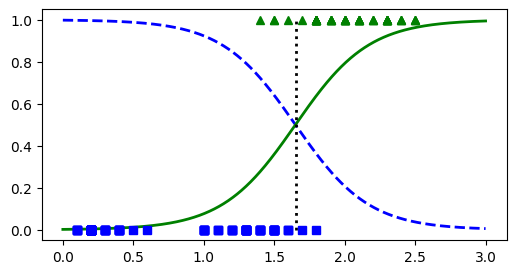

In [53]:
# cheking probabilities manually for petal width between 1 and 3

X_new = np.linspace(0,3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:,1]>=.5][0,0]
virginica_width = iris.data['petal width (cm)'][iris.target_names[iris.target] == 'virginica']
other_width = iris.data['petal width (cm)'][iris.target_names[iris.target] != 'virginica']

plt.figure(figsize=(6,3))
plt.plot(X_new, y_proba[:,0], 'b--', linewidth = 2, label = 'Not Iris virginica proba')
plt.plot(X_new, y_proba[:,1], 'g-', linewidth = 2, label='Iris virginica proba')
plt.plot([decision_boundary, decision_boundary], [0,1], 'k:', linewidth=2, label = 'Decision Boundary')
plt.plot(virginica_width, [1]*len(virginica_width), 'g^')
plt.plot(other_width, [0]*len(other_width), 'bs')
plt.show()

# In logistic regression model is not alpha as in other models it inverse c. The higher the value of c
# the less the model is regularized

In [56]:
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [58]:
softmax_reg.predict([[5, 2]])
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])